# RDBMS - MySQL 

## 00 - Introduction

Among the Relational DBMSs, the most widely known are Oracle, SQLite, Postgress, MariaDB, MySQL.

Each one of them is characterized by a different set of "variations" on top of the base SQL language, although usually minor.

We will use **MySQL** to run exercises about Relational DB transactions using the SQL language, as it is *today* at the top of the list of most widely used RDBs. 

https://db-engines.com/en/ranking_trend/relational+dbms

https://www.statista.com/statistics/809750/worldwide-popularity-ranking-database-management-systems/

https://insights.stackoverflow.com/survey/2021#most-popular-technologies-database

MySQL programming interfaces exist for many languages, including C, C++, Go, Java, Perl, PHP, Python, etc...

Even simply referring to Python, we can count on several options to connect and interact with the DBs. 

Let's explore a couple of them...

## 01 - Create a connection to MySQL 

A MySQL server is in execution on one of your Docker containers.

We can access it via the MySQL server credential we have defined in the docker-compose yml.

A `root` user is created by default with:
- user: `root`
- password: `root_pwd`

A non-`root` user is also created by default with:
- user: `my_user`
- password: `user_pwd`

#### Interactive 

We can interact with the MySQL server by logging in interactively to its docker container.

Check the `CONTAINER ID` of the container named `mysql_db` via:
    
```bash 
$ docker ps 
```

And run `bash` (or `/bin/bash`) in interactive mode attaching it to the terminal (`-it`) on the container:

```bash
$ docker exec -it <YOUR CONTAINER ID> bash
```

From inside the container we can use the RDBMS interface as if we were logged into a remote MySQL server hosting our DBs

```bash
$ mysql -u <EITHER ROOT OR USER> -p
``` 

We can then inspect the MySQL server to show us all DBs:
    
```mysql
SHOW DATABASES;
```

_NB_: remember to end a SQL command with a semicolon `;`

#### mysql.connector

A more pythonic way of communicating with a MySQL server is by using a dedicated driver.

We will use `mysql.connector`, which has already been installed in the Jupyter-notebook container for you.

The connector offers an interface to declare a connection object to the server, and provides a series of functionalities to issue transactions and fetch records from DBs.

We start by declaring a connection to our MySQL server.

_NB_: the server is hosted in a different container from the notebook... we are simulating a connection between two differen machines, a client and a server.

In [1]:
# import the connector
import mysql.connector

# declare a connection to the MySQL server 
# the hostname (or IP) of the server machine should be passed
#db just a python database connection
db = mysql.connector.connect(
  user="root",
  password="root_pwd",
  host="db", # in this case 'db' is the equivalent of the IP address of the server 
             # or 'localhost' if running mysql locally
)

print(db)

At this point a DB connection is enstablished

To interact with the DB via python and mysql.connector we need a "handle", known as a cursor, which has to be instantiated.

Using this connector to interact with the DB, all SQL statements are executed using the cursor.

In [2]:
# create our db cursor object
dbc = db.cursor()

The cursor allows to execute all SQL transactions on the DB as if we were logged into the server.

If a transaction will fetch a result from the DB (a set of records are returned), the connector object will retain the results.

This might come in handy for us to use it in a more "pythonic" way later on, interfacing our DB query with other Python statements.

The syntax for issuing a generic SQL statement is the following:

```python
connector_object.execute(my_sql_query)
```

For instance, let's try to execute the same check as before, by asking MySQL to show us all available DBs...

In [3]:
# show all available databases
dbc.execute(
"SHOW DATABASES"
)

No output is printed as the result of this SQL transaction is in fact "collected" into the cursor as a list of records (tuples).

We can simply loop over them to return the results.

In [4]:
# loop over the container to fetch the results
for _ in dbc:
    print(_)

('information_schema',)
('my_db',)
('mysql',)
('performance_schema',)
('sys',)


If we are `root` users in this example, we are able to see inner structure of the mysql server, which already contains a few dbs by default. 

Once fetched the output of the transaction, the cursor reaches "the end" of the records, and is available to perform a new transaction

In [5]:
for c_ in dbc:
    print(c_)

In the case one wants to perform a new transaction without collecting the output of the previos one from the cursor, a reset have to be issued first:

```python 
connector_object.reset()
```


In the case a generic user is instead logged into the db (i.e. non the `root` user), it will not have access to a set of functionalities, and will not be able to see the previous list of all databases.

Some of those are in fact protected and used to store additional information on the state of the MySQL server, the users connected, ...

In [6]:
udb = mysql.connector.connect(
  user="my_user",
  password="my_pwd",
  host="db",
)

udbc = udb.cursor()

udbc.execute(
"SHOW DATABASES"
)

for _ in udbc:
    print(_)

('information_schema',)


#### iPython magic

An alternative way to perform queries from Python over a Jupyter-notebook is by using some notebook "magic", based on iPython and SQLAlchemy.

This is a similar thing to what is usually done to load inline a figure from matplotlib (the `%matplotlib inline` thingy).

To instruct iPython to interpret SQL commands, and to connect to the proper DB we have to: 
1. load the extension for SQL language
2. set the environment variable to point to the connection to the DB

In [7]:
%load_ext sql

%env DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db

env: DATABASE_URL=mysql+mysqlconnector://root:root_pwd@db


Now, the notebooks cells can perform SQL transactions directly in plain SQL, by starting the cell with `%%sql`.

By default, the result is also printed with the `pretty` pandas-like format.

In [8]:
%%sql

SHOW DATABASES;

5 rows affected.


Database
information_schema
my_db
mysql
performance_schema
sys


An additional benefit is that a single `%slq` (not a double `%%sql`) can be used to join a SQL query with any Python command

In [9]:
my_python_var = %sql SHOW DATABASES

print(my_python_var)

 * mysql+mysqlconnector://root:***@db
5 rows affected.
+--------------------+
|      Database      |
+--------------------+
| information_schema |
|       my_db        |
|       mysql        |
| performance_schema |
|        sys         |
+--------------------+


The combination of either of the two pythonic methods can be used to easily redirect the output of DB transactions to exploit all other well-known python modules, e.g. plotting with matplotlib

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

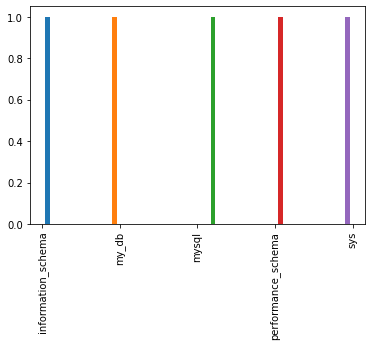

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(my_python_var)
plt.xticks(rotation='vertical')

## 02 Database and Table creation

We have already seen how we inspect the server to see which DBs are present via the command:

```mysql
SHOW DATABASES;
```

We can start interacting with a specific DB by selecting which one to use via 

```mysql
USE <DB_NAME>;
```

If instead we want to create a new DB to work with, we can use the command

```mysql
CREATE DATABASE <DB_NAME>;
```

A more complex sintax can be used to create a new DB if and only if no other DB with the same name already exists.

```mysql
CREATE DATABASE IF NOT EXISTS <DB_NAME>;
```

If the user has been granted the right to access this DB, it's possible to start investigating the content of the DB in use.

Check if a DB named `my_db` exist, and if not, create one. 
Then, switch to the new DB to start using it.

In [11]:
%%sql 
CREATE DATABASE IF NOT EXISTS my_db;
USE my_db;

 * mysql+mysqlconnector://root:***@db
1 rows affected.
0 rows affected.


[]

All tables contained in the DB are shown in a similar way to what used to show all DBs on the server:

```mysql
SHOW TABLES;
```

_NB_: we are inspecting the content of a specific DB (the one selected with `USE <DB_NAME>`)

In [12]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Tables_in_my_db
products
supplier_to_product
suppliers


The analogous pythonic way to execute the same list of commands (using the mysql.connector driver) is the following.

_NB_: This time, as we are not retrieving results from the server but we are instead creating a DB, we have to specify that we want to _commit_ a change to the server; 

In [13]:
# defining the sql command line
sql_ = "CREATE DATABASE IF NOT EXISTS my_db;"

# instructing the cursor to execute it
dbc.execute(sql_)

# in this case the result of the sql transaction is not to return a list of items 
# it is instead a change in the DB structure
# therefore, for the change to have effect, a the change is to be committed to the DB
db.commit() 

All other commands, `USE` and `SHOW`, do not require any change to be committed, therefore we can simply issue them via the cursor.

In [14]:
dbc.execute("USE my_db")

dbc.execute("SHOW TABLES")
for x in dbc:
    print(x)

('products',)
('supplier_to_product',)
('suppliers',)


So far the DB is empty, so let's use the same lines presented in the slides to create a dummy `Users` table.

Any table can then be inspected to check its schema by listing all attributes.

1. Create the `Users` table declaring the schema by defining each attributes
2. Check if the table has been created on the DB via a `SHOW` command
3. Check the Table schema by issuing `DESCRIBE <TABLE_NAME>`

In [15]:
%%sql

CREATE TABLE Users (
    UserID    varchar(30),
    BadgeNum  int(16),
    FirstName varchar(255),
    LastName  varchar(255),
    Age       int,
    OtherAttr float
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [16]:
%%sql

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Tables_in_my_db
Users
products
supplier_to_product
suppliers


In [17]:
%%sql

DESCRIBE Users;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


Field,Type,Null,Key,Default,Extra
UserID,b'varchar(30)',YES,,None,
BadgeNum,b'int',YES,,None,
FirstName,b'varchar(255)',YES,,None,
LastName,b'varchar(255)',YES,,None,
Age,b'int',YES,,None,
OtherAttr,b'float',YES,,None,


Following on the lines of the previous examples, perform the same transactions with the `mysql.connector` driver.

This time, as the `Users` table already exists, we can create a `Users_py` table.

Remember:
- Use the DB Cursor to execute the transactions
- Transaction that change the content of the DB have to be _committed_ to the DB
- Transactions returing the content of the DB host their results _in the cursor_

In [18]:
sql = 'CREATE TABLE Users_py (\
       UserID    varchar(30),\
       BadgeNum  int(16),\
       FirstName varchar(255),\
       LastName  varchar(255),\
       Age       int,\
       OtherAttr float);'
dbc.execute(sql)
db.commit()

In [19]:
dbc.execute("SHOW TABLES")
for x in dbc:
    print(x)

('Users',)
('Users_py',)
('products',)
('supplier_to_product',)
('suppliers',)


In [20]:
dbc.execute("DESCRIBE Users_py")
for x in dbc:
    print(x)

('UserID', b'varchar(30)', 'YES', '', None, '')
('BadgeNum', b'int', 'YES', '', None, '')
('FirstName', b'varchar(255)', 'YES', '', None, '')
('LastName', b'varchar(255)', 'YES', '', None, '')
('Age', b'int', 'YES', '', None, '')
('OtherAttr', b'float', 'YES', '', None, '')


## 03 Declaring contstraints and altering tables

Let's clean up all existing tables in our database.

To remove an existing table from a DB we can issue the instruction:
    
```mysql
DROP TABLE IF EXISTS <NAME OF YOUR TABLE>;
```

Be ***extremely careful*** when doing this... Dropping a Table means losing all records from that table, and severing all connections with other tables based on foreign keys. The entire DB might become unusable!


In [21]:
%%sql 

DROP TABLE IF EXISTS Users;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

Let's also drop the `Users_py` table using the Python connetor

In [22]:
dbc.execute("DROP TABLE IF EXISTS Users_py")
db.commit()

In [23]:
dbc.execute("SHOW TABLES")
for x in dbc:
    print(x)

('products',)
('supplier_to_product',)
('suppliers',)


Create a new `products` table with the following schema:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |

`productID` will also be our `PRIMARY KEY`

This can be declared either inline or at the end of the table definition:

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY
```

or 

```mysql
productID INT NOT NULL UNIQUE AUTO_INCREMENT
...
PRIMARY KEY (productID)
```

In [24]:
%%sql

CREATE TABLE IF NOT EXISTS products (
         productID    INT          NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
         productName  VARCHAR(30)  DEFAULT "" ,
         unitPrice    FLOAT        NOT NULL DEFAULT 99999.99,
         unitsInStock INT UNSIGNED NOT NULL DEFAULT 0
);

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [25]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,None,
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


The table does not contain any constraint, default values, or keys.

A table can be altered by adding/removing Attributes, as well as by adding constraints.

Let's first add a new attribute to the table:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| **isDiscontinued**  | **Bool** | | NOT NULL |

To alter a table and create a new column we can act on it with:

```mysql
ALTER TABLE <THE TABLE>
ADD COLUMN <NEW COL> <THE NEW ATTRIBUTE DECLARATION>;
```


Alter the `products` table and add the `isDiscontinued` attribute

In [26]:
%%sql

ALTER TABLE products
ADD COLUMN isDiscontinued BOOL NOT NULL;

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1060 (42S21): Duplicate column name 'isDiscontinued'
[SQL: ALTER TABLE products ADD COLUMN isDiscontinued BOOL NOT NULL;]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [27]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,None,
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


`isDiscontinued` does however not contain any meaningful constraint or default value.
Let's consider `0` as a good default value:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL **DEFAULT 0** |


We can use the same `ALTER TABLE` instruction to do this:
    
```mysql
ALTER TABLE <THE TABLE>
ALTER <ATTRIBUTE> SET DEFAULT <NEW DEFAULT>;
```

In [28]:
%%sql 

ALTER TABLE products 
ALTER isDiscontinued SET DEFAULT 0;

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [29]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,None,
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


We can also impose `productName` to be not-null altering the table one final time.

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| productID   | Integer | | NOT NULL AUTO_INCREMENT |
| productName | String | Max length 30 | **NOT NULL** DEFAULT "" |
| unitPrice   | Float | | NOT NULL DEFAULT 99999.99|
| unitsInStock | Integer | Unsigned | NOT NULL DEFAULT 0 |
| isDiscontinued  | Bool | | NOT NULL DEFAULT 0 |


In MySQL, this implies to modify the entire attribute, thus the Type will have to be re-stated:
    
```mysql
ALTER TABLE <THE TABLE>
MODIFY <ATTRIBUTE> <ATTRIBUTE TYPE> <CONSTRAINT>;
```

In [30]:
%%sql

ALTER TABLE products
MODIFY productName VARCHAR(30) NOT NULL; #NOW IT HAS TO BE A STRING OF MAX LENGTH 30
# NOT NULL LIKE ABOVE

 * mysql+mysqlconnector://root:***@db
0 rows affected.
0 rows affected.


[]

In [31]:
%%sql

DESCRIBE products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


Field,Type,Null,Key,Default,Extra
productID,b'int',NO,PRI,None,auto_increment
productName,b'varchar(30)',NO,,None,
unitPrice,b'float',NO,,b'100000',
unitsInStock,b'int unsigned',NO,,b'0',
isDiscontinued,b'tinyint(1)',NO,,b'0',


Let's now create a `suppliers` table with the following description:

| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| supplierID   | Integer | | NOT NULL AUTO_INCREMENT |
| supplierName | String | Max length 30 | NOT NULL DEFAULT "" |
| countryCode   | Char | Length 3 | NOT NULL |
| email   | String | Max length 30  | NOT NULL |

`supplierID` is going to act as the table's primary key in this case.

In [32]:
%%sql

CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);


 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1050 (42S01): Table 'suppliers' already exists
[SQL: CREATE TABLE suppliers (
    supplierID      INT NOT NULL UNIQUE AUTO_INCREMENT PRIMARY KEY,
    supplierName    VARCHAR(30) NOT NULL DEFAULT "",
    countryCode     CHAR(3) NOT NULL,
    email           VARCHAR(30) NOT NULL
);]
(Background on this error at: https://sqlalche.me/e/14/f405)


CHAR(3) is always length 3
VARCHAR(30) is max length 30

In [33]:
%%sql 

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'---',
email,b'varchar(30)',NO,,None,


Alter the table to include a default "ITA" for `countryCode`

In [34]:
%%sql 

ALTER TABLE suppliers 
ALTER countryCode SET DEFAULT "---";

 * mysql+mysqlconnector://root:***@db
0 rows affected.


[]

In [35]:
%%sql 

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'---',
email,b'varchar(30)',NO,,None,


To enstablish a relation between the `products` and `suppliers` tables, we have to consider that:
    
- a supplier can supply multiple products
- a product can be supplied by multiple suppliers

This is a many-to-many relationship, which requires a supporting external table.

Create a new `supplier_to_product` table with the following attributes:
    
| Attribute | Type | Extra info | Constraint | 
| --- | --- | --- |--- |
| prodID   | Integer | | NOT NULL |
| supID    | Integer | | NOT NULL |


In [36]:
%%sql

CREATE TABLE supplier_to_product (
    prodID     INT NOT NULL,
    supID      INT NOT NULL
);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1050 (42S01): Table 'supplier_to_product' already exists
[SQL: CREATE TABLE supplier_to_product (
    prodID     INT NOT NULL,
    supID      INT NOT NULL
);]
(Background on this error at: https://sqlalche.me/e/14/f405)


Neither prodID nor supID is a good primary key in this case, as we can have both appearing multiple times in the table.

However, a good primary key for this table is the combination (prodID,supID) which is absolutely unique, and thus, a good key.

We can alter the table to add the primary key statement:
    
```mysql
ALTER TABLE <TABLE>
ADD PRIMARY KEY <ATTRIBUTE COMBINATION>;
```

In [37]:
%%sql

ALTER TABLE supplier_to_product
ADD PRIMARY KEY (prodID, supID);

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1068 (42000): Multiple primary key defined
[SQL: ALTER TABLE supplier_to_product ADD PRIMARY KEY (prodID, supID);]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [38]:
%%sql 

DESCRIBE supplier_to_product;

 * mysql+mysqlconnector://root:***@db
2 rows affected.


Field,Type,Null,Key,Default,Extra
prodID,b'int',NO,PRI,None,
supID,b'int',NO,PRI,None,


Finally, we can link the 3 tables together by stating which attributes act as the foreign keys in the `supplier_to_product` table, and to which Attributes in the parent tables they refer to.

- `prodID` points to the `productID` attribute of `products` table
- `supID` points to the `supplierID` attribute of `supplier` table

```mysql
ALTER TABLE <TABLE>
ADD FOREIGN KEY (<ATTRIBUTE IN THIS TABLE>) REFERENCES <OTHER TABLE>(<ATTRIBUTE IN OTHER TABLE>);
```

In [39]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);

 * mysql+mysqlconnector://root:***@db


DatabaseError: (mysql.connector.errors.DatabaseError) 1826 (HY000): Duplicate foreign key constraint name 'FK_prod'
[SQL: ALTER TABLE supplier_to_product ADD CONSTRAINT FK_prod
FOREIGN KEY (prodID) REFERENCES products(productID);]
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [40]:
%%sql 

ALTER TABLE supplier_to_product 
ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);

 * mysql+mysqlconnector://root:***@db


DatabaseError: (mysql.connector.errors.DatabaseError) 1826 (HY000): Duplicate foreign key constraint name 'FK_sup'
[SQL: ALTER TABLE supplier_to_product ADD CONSTRAINT FK_sup
FOREIGN KEY (supID) REFERENCES suppliers(supplierID);]
(Background on this error at: https://sqlalche.me/e/14/4xp6)

In [41]:
db%%sql 

DESCRIBE supplier_to_product;

SyntaxError: invalid syntax (3151562527.py, line 1)

## 04 Inserting Updating and Deleting records

The tables are currently empty. 
We can inspect the content of the tables by performing a simple query.

```mysql
SELECT * FROM <TABLE>;
```

To insert a single record into a table we can proceed in either of the two following ways:

1. By explicitly specifying the names of the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES (<VALUE1>, <VALUE2>, <VALUE3>, ...);
```
This will work also in the case attributes with a default value will not be explicitely passed


2. By implicitly using all the columns when passing the tuple containing the values
```mysql
INSERT INTO <TABLE> 
VALUES (<VALUE1>, <VALUE2>, ..., <VALUEn>);
```


_NB_: 1. is the usually recommended way to perform a data insertion in SQL.

Using the `mysql.connector` we can formulate the insert in a more pythonic way, e.g. to include this statement programmatically into a loop or a function call:
    
```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = (<VALUE1>, <VALUE2>, <VALUE3>, ...)
db_cursor.execute(sql_, val_)
db.commit()
```

Being an active change to the DB istance (the data contained in the DB itself), remember to commit the insert.

- Verify that the product table is actually empty
- Isert the following list of products in the `products` table
- Check the content of the table after the transaction, to verify that both the AUTO_INCREMENT key and the default values have taken into account


| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Founders Porter" | 4.9 | 12 | 0 |


In [42]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0


In [43]:
%%sql

INSERT INTO products (productName, unitPrice, unitsInStock)
VALUES ('Founders Porter',4.9 ,12);

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [44]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
5 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0


Multi-values insert can be performed in a completely similar way, by separating multiple tuples by a comma:
    
```mysql
INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...)
VALUES 
(<VALUE11>, <VALUE12>, <VALUE13>, ...), 
(<VALUE21>, <VALUE22>, <VALUE23>, ...), 
(<VALUE31>, <VALUE32>, <VALUE33>, ...), 

```

The python-based command is similar to the previous one, but is drop the `execute` in favor of `executemany`, using as value a list of tuples

```python
sql_ = "INSERT INTO <TABLE> (<COLUMN1>, <COLUMN2>, <COLUMN3>, ...) VALUES (%s, %s, %s, ...)"
val_ = [
    (<VALUE11>, <VALUE12>, <VALUE13>, ...),
    (<VALUE21>, <VALUE22>, <VALUE23>, ...),
    (<VALUE31>, <VALUE32>, <VALUE33>, ...) ]
db_cursor.executemany(sql_, val_)
db.commit()
```


Add a few more products to the `product` table:
    
| productName | unitPrice | unitsInStock | isDiscontinued | 
| --- | --- | --- |--- |
| "Punk IPA" | 5.2 | 45 |  |
| "HB Dunkel" | 4.5 | 250 |  |
| "Forst Xmas " | 8.0 | 2 |  |
| "Damm Complot " | 3.7 | 120 |  |
     

In [45]:
sql_ = "INSERT INTO products (productName, unitPrice, unitsInStock) VALUES (%s, %s, %s)"
val_ = [
    ('Punk IPA',     5.2,  45),
    ('HB Dunkel',    4.5, 250),
    ('Forst Xmas',   8.0,   2),
    ('Damm Complot', 3.7, 120)]
dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM products"); 
for _ in dbc:
     print(_)

(1, 'Founders Porter', 4.9, 12, 0)
(2, 'Punk IPA', 5.2, 45, 0)
(3, 'HB Dunkel', 4.5, 250, 0)
(5, 'Damm Complot', 3.7, 120, 0)
(6, 'Founders Porter', 4.9, 12, 0)
(7, 'Punk IPA', 5.2, 45, 0)
(8, 'HB Dunkel', 4.5, 250, 0)
(9, 'Forst Xmas', 8.0, 2, 0)
(10, 'Damm Complot', 3.7, 120, 0)


Updating entries is a more delicate issue, as in a DB we can in principle modify all records associated with a number of conditions.
This makes the update operation quite powerful and possibly very error prone if not performed with extreme caution.

```mysql
UPDATE <TABLE>
SET <ATTRIBUTE> = <NEW VALUE>
WHERE <CONDITION>;
```

or

```python
sql_ = "UPDATE <TABLE> SET <ATTRIBUTE> = <NEW VALUE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

Let's update a single record with a "very explicit" condition statement:

- Assign `isDiscontinued` equal to 1 to the "Forst Xmas" product
- Check if the update has taken place

In [46]:
%%sql

UPDATE products 
SET isDiscontinued = 1
WHERE productName = "Forst Xmas";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

Similarly, deleting entries is quite a risky task if not done with plenty of caution, as a wrong `WHERE` condition might inadvertly lead to the deletion of a large part of your DB records. 

Remember, with `DELETE` we do remove entire records (i.e. tuples) from the DB, not just the content of the `WHERE` conditional statement. 

```mysql
DELETE FROM <TABLE>
WHERE <CONDITION>;
```

or

```python
sql_ = "DELETE FROM <TABLE> WHERE <CONDITION>"
db_cursor.execute(sql)
db.commit()

```

- Delete all products whose name begins with 'F' and ends with 's'
- Check if the update has taken place

In [47]:
%%sql

DELETE FROM products 
WHERE productName LIKE "F%s";

 * mysql+mysqlconnector://root:***@db
1 rows affected.


[]

In [48]:
%%sql

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
8 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0


- Populate the `suppliers` table according to the following list


| supplierName | countryCode | email|
| --- | --- | ---|
| "A hop in the park" | "USA" | "contactme@ahop.com" |
| "Allez Hops! Cave à bièr" | "FRA" | "itsme@allezhops.com" |
| "Wild Hops " | "ITA" | "myemail@wildhops.it" |
|"Beer Paradise"|"ITA"|"beer@beerparadise.it"|


In [49]:
%%sql

INSERT INTO suppliers (supplierName, countryCode, email) VALUES
("A hop in the park","USA","contactme@ahop.com"),
("Allez Hops! Cave à bièr","FRA","itsme@allezhops.com"),
("Wild Hops","ITA","myemail@wildhops.it"),
("Beer Paradise","ITA","beer@beerparadise.it");

 * mysql+mysqlconnector://root:***@db
4 rows affected.


[]

In [50]:
%%sql

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
8 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it
5,A hop in the park,USA,contactme@ahop.com
6,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
7,Wild Hops,ITA,myemail@wildhops.it
8,Beer Paradise,ITA,beer@beerparadise.it


Complete the DB with the two additional steps:

- Update the "A hop in the park" email address to "anewemail@ahop.com"
- Populate the table of connections between products and suppliers
    - Remember that the `supplier_to_product` table is linked to the other two via the respective Foreign Keys 

| supplier | products provided |
| --- | --- | 
| "A hop in the park" | "Punk IPA", "HB Dunkel" |

In [51]:
sql_ = "UPDATE suppliers SET email = %s WHERE supplierName LIKE %s;"
val_ = ('anewemail@ahop.com', 'A hop%')
dbc.execute(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM suppliers"); 
for _ in dbc:
     print(_)

(1, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(2, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(3, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(4, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')
(5, 'A hop in the park', 'USA', 'anewemail@ahop.com')
(6, 'Allez Hops! Cave à bièr', 'FRA', 'itsme@allezhops.com')
(7, 'Wild Hops', 'ITA', 'myemail@wildhops.it')
(8, 'Beer Paradise', 'ITA', 'beer@beerparadise.it')


In [52]:
%%sql 

SELECT * FROM products;

 * mysql+mysqlconnector://root:***@db
8 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0
10,Damm Complot,3.7,120,0


In [53]:
%%sql 

SELECT * FROM suppliers;

 * mysql+mysqlconnector://root:***@db
8 rows affected.


supplierID,supplierName,countryCode,email
1,A hop in the park,USA,anewemail@ahop.com
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
3,Wild Hops,ITA,myemail@wildhops.it
4,Beer Paradise,ITA,beer@beerparadise.it
5,A hop in the park,USA,anewemail@ahop.com
6,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com
7,Wild Hops,ITA,myemail@wildhops.it
8,Beer Paradise,ITA,beer@beerparadise.it


In [54]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


prodID,supID
2,1
3,1
1,2
3,2
1,3
2,3
3,3
5,3
2,4
5,4


In [55]:
%%sql

INSERT INTO supplier_to_product
VALUES 
(2,1),
(3,1);

 * mysql+mysqlconnector://root:***@db


IntegrityError: (mysql.connector.errors.IntegrityError) 1062 (23000): Duplicate entry '2-1' for key 'supplier_to_product.PRIMARY'
[SQL: INSERT INTO supplier_to_product VALUES 
(2,1),
(3,1);]
(Background on this error at: https://sqlalche.me/e/14/gkpj)

In [56]:
%%sql 

SELECT * FROM supplier_to_product;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


prodID,supID
2,1
3,1
1,2
3,2
1,3
2,3
3,3
5,3
2,4
5,4


Export the DB you have created into a .sql file, and store it for later use.

1. connect to the "server" docker container using bash
2. dump the DB via the command:
    
```bash
$ mysqldump -u <USER> -p <DB NAME>  >  <FULL/PATH/TO/NEW/DB_DUMP.sql>
```

3. use the folder `/opt/workspace/dbs` to store the file, as it's the one currently visible from both in- and out-side the container

should know the > operator 

## 04 Basic queries 

The `SELECT` statement allows to perform queries and to retrieve data from a DB.

We can perform queries on 1 single Table in the DB, as well as perform complex queries that span multiple interconnected Tables, with one-to-one, one-to-many and many-to-many relationships across records.

Any `SELECT` statement is composed by at least:
    
```mysql
SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>   --# the list of attributes to show
                                                  --# the * wildcard symbol means ALL attributes
    
FROM <TABLE1>, <TABLE2>                           --# the table, or list of tables 
                                                  --# from which to extract the attributes

WHERE <CONDITIONS>                                --# (optional) condition statement
```

The same goes for the pythonc connector-based way

```python
db_cursor.execute("""SELECT <TABLE2.ATTRIBUTE1>, <TABLE1.ATTRIBUTE2>"""
                  """FROM <TABLE1>, <TABLE2>"""
                  """WHERE <CONDITIONS>""")
res_ = db_cursor.fetchall()
for _ in res_:
    print(_)
```

As an alternative, `db_cursor.fetchone()` can be used to printout only 1 out of possibly many records.


- Get the email of all suppliers from Italy

In [57]:
%%sql 

SHOW TABLES;

 * mysql+mysqlconnector://root:***@db
3 rows affected.


Tables_in_my_db
products
supplier_to_product
suppliers


In [58]:
%%sql

SELECT email
FROM suppliers
WHERE countryCode="ITA";

 * mysql+mysqlconnector://root:***@db
4 rows affected.


email
myemail@wildhops.it
beer@beerparadise.it
myemail@wildhops.it
beer@beerparadise.it


- Get all information for products with unit price greater than 4

In [59]:
%%sql

SELECT *
FROM products
WHERE unitPrice>4;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
1,Founders Porter,4.9,12,0
2,Punk IPA,5.2,45,0
3,HB Dunkel,4.5,250,0
6,Founders Porter,4.9,12,0
7,Punk IPA,5.2,45,0
8,HB Dunkel,4.5,250,0


- Select all products with less unit cost less than 5 and list them in descending order of units in stock

In [60]:
%%sql

SELECT *
FROM products
WHERE unitPrice<5
ORDER BY unitsInStock DESC;

 * mysql+mysqlconnector://root:***@db
6 rows affected.


productID,productName,unitPrice,unitsInStock,isDiscontinued
3,HB Dunkel,4.5,250,0
8,HB Dunkel,4.5,250,0
5,Damm Complot,3.7,120,0
10,Damm Complot,3.7,120,0
1,Founders Porter,4.9,12,0
6,Founders Porter,4.9,12,0


**Group by** is a common statement which allows to perform data aggregation.

If familiar with `pandas`, this should not come any new to you.

Just remember:
1. No group by statement is possible without an aggregation function.
2. Group by are quite computationally expensive. In case of large databases group by operations might require a long time to execute

- plot the distribution of suppliers by country

%sql row in sql
%%sql whole cell
Need to count

In [61]:
%%sql 

SELECT COUNT(countryCode)
FORM suppliers
GROUP BY countryCode;

 * mysql+mysqlconnector://root:***@db
(mysql.connector.errors.ProgrammingError) 1064 (42000): You have an error in your SQL syntax; check the manual that corresponds to your MySQL server version for the right syntax to use near 'suppliers
GROUP BY countryCode' at line 1
[SQL: SELECT COUNT(countryCode) FORM suppliers
GROUP BY countryCode;]
(Background on this error at: https://sqlalche.me/e/14/f405)


In [62]:
%%sql 

DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'---',
email,b'varchar(30)',NO,,None,


 * mysql+mysqlconnector://root:***@db
3 rows affected.
+-------+-------------+
| count | countryCode |
+-------+-------------+
|   2   |     USA     |
|   2   |     FRA     |
|   4   |     ITA     |
+-------+-------------+


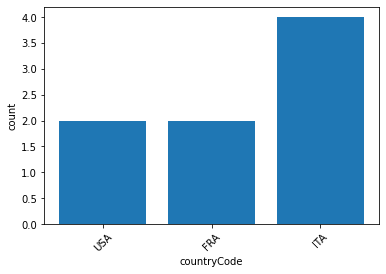

In [63]:
res_ = %sql SELECT COUNT(countryCode) AS count, countryCode FROM suppliers GROUP BY countryCode;
#outout of sql is printed in python with this
print (res_);

res_.bar();

The main strength of Relational DBs is the possibility of matching information from different tables though **Join** operations.

A join, either performed explicitely or implicitely is:

Just remember:
1. Computationally expensive. In case of large databases group by operations might require a long time to execute
2. Very easy to be done wrong, thus resulting in non-meaningful results

Be sure on which attributes (most often keys) you are performing a join operation.

- Join the `supplier_to_product` table with the `suppliers` table 

In [70]:
%%sql 
DESCRIBE suppliers;

 * mysql+mysqlconnector://root:***@db
4 rows affected.


Field,Type,Null,Key,Default,Extra
supplierID,b'int',NO,PRI,None,auto_increment
supplierName,b'varchar(30)',NO,,b'',
countryCode,b'char(3)',NO,,b'---',
email,b'varchar(30)',NO,,None,


In [64]:
%%sql

SELECT * 
FROM suppliers, supplier_to_product
WHERE supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


In [65]:
%%sql

SELECT * 
FROM suppliers
INNER JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


In [66]:
%%sql

SELECT * 
FROM suppliers
LEFT JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
14 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


In [67]:
%%sql

SELECT * 
FROM suppliers
RIGHT JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID
1,A hop in the park,USA,anewemail@ahop.com,2,1
1,A hop in the park,USA,anewemail@ahop.com,3,1
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2
3,Wild Hops,ITA,myemail@wildhops.it,1,3
3,Wild Hops,ITA,myemail@wildhops.it,2,3
3,Wild Hops,ITA,myemail@wildhops.it,3,3
3,Wild Hops,ITA,myemail@wildhops.it,5,3
4,Beer Paradise,ITA,beer@beerparadise.it,2,4
4,Beer Paradise,ITA,beer@beerparadise.it,5,4


We can concatenate multiple join operations to extract higher level information out of the connections stored in the DB

- Add the corresponding product names the the previous join

In [68]:
%%sql

SELECT * 
FROM suppliers
INNER JOIN supplier_to_product ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID;

 * mysql+mysqlconnector://root:***@db
10 rows affected.


supplierID,supplierName,countryCode,email,prodID,supID,productID,productName,unitPrice,unitsInStock,isDiscontinued
1,A hop in the park,USA,anewemail@ahop.com,2,1,2,Punk IPA,5.2,45,0
1,A hop in the park,USA,anewemail@ahop.com,3,1,3,HB Dunkel,4.5,250,0
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,1,2,1,Founders Porter,4.9,12,0
2,Allez Hops! Cave à bièr,FRA,itsme@allezhops.com,3,2,3,HB Dunkel,4.5,250,0
3,Wild Hops,ITA,myemail@wildhops.it,1,3,1,Founders Porter,4.9,12,0
3,Wild Hops,ITA,myemail@wildhops.it,2,3,2,Punk IPA,5.2,45,0
3,Wild Hops,ITA,myemail@wildhops.it,3,3,3,HB Dunkel,4.5,250,0
3,Wild Hops,ITA,myemail@wildhops.it,5,3,5,Damm Complot,3.7,120,0
4,Beer Paradise,ITA,beer@beerparadise.it,2,4,2,Punk IPA,5.2,45,0
4,Beer Paradise,ITA,beer@beerparadise.it,5,4,5,Damm Complot,3.7,120,0


The conjunction of `SELECT`, `GROUP BY` and `JOIN` statements will allow us to extract non trivial information out of any Relational DB.

Add the following records to the `supplier_to_product` table and perform the following queries:
    
| supplier | products provided |
| --- | --- | 
| "Wild Hops" | "Founders Porter", "Punk IPA", "HB Dunkel", "Damm Complot" |    
| "Beer Paradise" | "Punk IPA", "Damm Complot" |    
| "Allez Hops! Cave à bièr" | "Founders Porter", "HB Dunkel" |    

1. show all suppliers of "Damm Complot"
2. retrieve the email address of all possible suppliers of "Punk IPA"
3. list the unit price of all products supplied by Italian firms, lister in descending order   

In [69]:
sql_ = "INSERT INTO supplier_to_product (prodID, supID) VALUES (%s, %s)"
val_ = [
    # supplier Allez Hops
    (1, 2),
    (3, 2),

    # supplier Wild Hops
    (1, 3),
    (2, 3),
    (3, 3),
    (5, 3),

    # supplier Beer Paradise
    (2, 4),
    (5, 4),
]


dbc.executemany(sql_, val_)
db.commit()
     
dbc.execute("SELECT * FROM supplier_to_product"); 
for _ in dbc:
     print(_)

IntegrityError: 1062 (23000): Duplicate entry '1-2' for key 'supplier_to_product.PRIMARY'

In [ ]:
%%sql

SELECT suppliers.supplierName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

In [ ]:
%%sql

SELECT suppliers.email 
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE products.productName = "Punk IPA";

In [ ]:
%%sql

SELECT DISTINCT products.unitPrice, products.productName
FROM supplier_to_product
INNER JOIN suppliers ON supplier_to_product.supID = suppliers.supplierID
INNER JOIN products ON supplier_to_product.prodID = products.productID
WHERE suppliers.countryCode = "ITA"
ORDER BY unitPrice DESC;

## 05 Queries on well-formed DBs

In MySQL we can load entire DBs from external files.

The files will contain the full DB structure (tables and constraints) and will populate all tables with all records 

To load a DB into the MySQL server from the interactive docker shell, we can simply do the following:

1. Create a new DB named `world`
2. Import the content of the file `/opt/workspace/dbs/world.sql` into the newly created DB via
    
```bash
$ mysql -u root -p world < /opt/workspace/dbs/world.sql
```

_NB_: The `opt/workspace` directory has been defined as a Docker Volume, and is a shared location with your computer...

Using the `world` DB, perform queries to answer the folliwing questions.

Additional references can be found here https://dev.mysql.com/doc/world-setup/en/


Use a single query to answer the questions

1. Which country has the largest population?
2. Get the total number of cities in Canada.
3. Select the country with the most cities.
4. List all the languages spoken in the Southeast Asia region.
5. Identify the 5 most spoken language by number of countries.
6. What is the total population of the cities in the Caribbean region?
7. What Countries have a City named "Kingston"?
8. Plot the population density by country, limiting to the 25 with least density.
9. Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.
10. Plot the correlation between the life expentency and the GNP of all countries that have Spanish as their Official language.



Suggestions:
- Start by inspecting the DB tables structure
- When in doubt, check the table content by selecting a few lines (use `LIMIT` to avoid returining all records)
- Before finalizing the query, you can always perform "intermediate" queries to check if complex operations (groupby and join mostly) are stated correctly

In [ ]:
%%sql

USE world; 

SHOW TABLES;

#### 1 - Which country has the largest population?

In [ ]:
%%sql 

SELECT Name, Population 
FROM city
ORDER BY Population DESC
LIMIT 1;

#### 2 - Get the total number of cities in Canada.

In [ ]:
%%sql 

SELECT COUNT(Name) AS CitiesInCanada
FROM city
WHERE CountryCode = "CAN";

#### 3 - Select the country with the most cities.

In [ ]:
%%sql 

SELECT CountryCode, COUNT(1) AS nCities
FROM city
GROUP BY CountryCode
ORDER BY nCities DESC
LIMIT 1;

#### 4 - List all the languages spoken in the 'Southeast Asia' region.

In [ ]:
%%sql

SELECT Region, COUNT(1) 
FROM country 
WHERE Region LIKE "%Asia"
GROUP BY Region;

In [ ]:
%%sql

SELECT DISTINCT countrylanguage.Language
FROM country, countrylanguage 
WHERE country.Region = "Southeast Asia"
AND country.Code = countrylanguage.countryCode
ORDER BY countrylanguage.Language ASC;

#### 5 - Identify the 5 most spoken language by number of countries.

In [ ]:
%%sql

SELECT Language, COUNT(Language) AS count 
FROM countrylanguage
GROUP BY Language
ORDER BY COUNT(Language) DESC
LIMIT 5;


#### 6 - What is the total population of the cities in the Caribbean region?

In [ ]:
%%sql

SELECT SUM(city.Population)
FROM city
LEFT JOIN country ON city.countryCode = country.Code
WHERE country.Region = 'Caribbean';


#### 7 - What Countries have a City named "Kingston"?

In [ ]:
%%sql

SELECT country.Name, country.Region
FROM country
RIGHT JOIN city ON city.countryCode = country.Code
WHERE city.Name = 'Kingston';


#### 8 - Plot the population density by country, limiting to the 25 with least density.

In [ ]:
res_ = %sql SELECT Name, Population/SurfaceArea AS PopDensity FROM country ORDER BY PopDensity ASC LIMIT 25;

print(res_)

plt.figure(figsize=(16,3))
res_.bar()
plt.xticks(rotation='vertical')

### 9 - Plot the GNP (Gross Nation Product) of all countries that become independent between 1850 and 1910, limiting to the 10 with highest GNP.

In [ ]:
res_ = %sql SELECT Name, GNP FROM country WHERE IndepYear BETWEEN 1850 AND 1910 ORDER BY GNP DESC;

print(res_)

plt.figure(figsize=(16,3))
res_.bar()
plt.xticks(rotation='vertical')

#### 10 - Plot the correlation between the life expentency and the GNP of all countries that have Spanish as their Official language.

In [ ]:
res_ = %sql SELECT LifeExpectancy, GNP, country.Name \
FROM country \
RIGHT JOIN countrylanguage ON countrylanguage.countryCode = country.Code \
WHERE Language = 'Spanish' \
AND IsOfficial = 1;

print(res_)

plt.figure(figsize=(8,6))
for _ in res_:
    plt.scatter(_[0],_[1],s=50)
    plt.annotate(_[2], (float(_[0])*1.002,float(_[1])*1.002))
plt.ylabel('GNP')
plt.xlabel('LifeExpectancy')


## 06 More on queries 

Let' import a well-structured DB, with several tables and relationships, to be used as a sandbox for further exercises on queries.

The `.sql` file can be found at: `/opt/workspace/dbs/IMDb_pruned.sql`.

The DB is freely available and is taken from the IMDb (Internet Movie Database) website (https://www.imdb.com/interfaces/).

The entire database is composed of a dozen of tables, hosing all people involved in Movies, Shorts, TV Show Epidoses and more since the 1890s. 

To simplify the execution of queries, we will work with a slimmed-down version of the entire DB, with still plenty of records for us to extract interesting information.

1. Create a new DB named `IMDb`
2. Import the content of the file `/opt/workspace/dbs/IMDb_pruned.sql` into the newly created DB
(this might take a minute or two...)

### Check which tables are available

In [ ]:
import pandas as pd

In [ ]:
%%sql

USE IMDb;

SHOW TABLES;

### Describe the content of table Names_

In [ ]:
%%sql 

DESCRIBE Names_;

### People by birth year

A) Start by limiting the query to 1000 entries

1. Draw an histogram of the year of birth
2. Draw a second histogram with the year of birth of the 1000 youngest people in the list

In [ ]:
# db = mysql.connector.connect(
#   user="root",
#   password="root_pwd",
#   host="db"
# )

# dbc = db.cursor()

dbc.execute("USE IMDb")

import itertools
dbc.execute("SELECT birth_year FROM Names_ LIMIT 1000")
myresult = dbc.fetchall()  
# plt.hist([x[0] for x in myresult])       # list-comprehension of 0-th elements in tuple
# plt.hist(list(zip(*myresult))[0])        # un-zip the tuple in a list and take the 0-the element
plt.hist(list(itertools.chain(*myresult))) # un-wrap the tuple in a list


# The same could be done by selecting *.
# In this case though, the returned value 
# retains the table schema
# 
# dbc.execute("SELECT * FROM Names_ LIMIT 1000")
# myresult = dbc.fetchall()    
# plt.hist([x[2] for x in myresult])
# plt.hist(list(zip(*myresult))[2])


In [ ]:
dbc.execute("SELECT birth_year FROM Names_ ORDER BY birth_year DESC LIMIT 1000 ")
myresult = dbc.fetchall()  
plt.hist(list(itertools.chain(*myresult)))

B) Extend the query to all records in the table

1. Check for outliers (inspect min and max)
2. If any outlier is found, limit the query to a reasonable range (at least people born after 1850)
3. Draw a new histogram with the year of birth
4. Compute the mean and std of year of birth

In [ ]:
%%sql

USE IMDb;

SELECT MIN(birth_year),MAX(birth_year) FROM Names_;

In [ ]:
%%sql

SELECT COUNT(*),MIN(birth_year),MAX(birth_year) 
FROM Names_ 
WHERE (birth_year < 1850);

In [ ]:
%%sql

SELECT *
FROM Names_ 
WHERE (birth_year < 1850);

In [ ]:
dbc.execute("SELECT birth_year\
             FROM Names_\
             WHERE (birth_year > 1850)")
myresult = dbc.fetchall()  
plt.hist(list(itertools.chain(*myresult)),
        bins=50)

In [ ]:
_ = %sql SELECT AVG(birth_year) AS mean, STD(birth_year) AS std FROM Names_ WHERE (birth_year > 1850)

print (_)

### Movie stats

1. Plot how many titles can be found in the DB per year, over the past 25 years
2. List the names of all actors who have had the role of Spider-Man and the corresponding Title
3. List and count the 10 people who appeared the most in movies by "Wes Anderson"

#### 1 - Plot how many titles can be found in the DB per year, over the past 25 years

In [ ]:
%%sql 

DESCRIBE Titles;

In [ ]:
%%sql 

SELECT start_year AS year, COUNT(*) AS count
FROM Titles 
WHERE (start_year >= 1997) 
GROUP BY start_year
ORDER BY start_year DESC;

In [ ]:
res_ = %sql SELECT start_year AS year, COUNT(*) AS count FROM Titles WHERE (start_year >= 1997) GROUP BY start_year ORDER BY start_year DESC;

In [ ]:
# the result of a query is also a special type that can be casted into a variety of formats
print(type(res_))

print('DICTIONARY\n\n {} \n\n'.format(res_.dict()))
print('CSV\n\n {} \n\n'.format(res_.csv()))
print('PANDAS DATAFRAME\n\n')
res_.DataFrame()

In [ ]:
# we can thus use the dict to plot the results
plt.plot('year',
         'count',
         data = res_.dict())
plt.xlabel('years')
plt.ylabel('counts')

In [ ]:
# however, the sql result class also include a number of built-in features, such as automated plotting
res_.plot()

#### 2 - List the names of all actors who have had the role of Spider-Man and the corresponding Title 

In [ ]:
%%sql

DESCRIBE Had_role;

In [ ]:
%%sql

DESCRIBE Names_;

In [ ]:
%%sql

DESCRIBE Titles;

In [ ]:
%%sql

SELECT DISTINCT Names_.name_ 
FROM Names_ 
WHERE ( 
    Names_.name_id IN ( 
        SELECT Had_role.name_id 
        FROM Had_role  
        WHERE (Had_role.role_ LIKE "Spider-Man") 
    ) 
);

In [ ]:
%%sql 

SELECT DISTINCT Titles.primary_title 
FROM Titles 
WHERE ( 
    Titles.title_id IN ( 
        SELECT Had_role.title_id 
        FROM Had_role  
        WHERE (Had_role.role_ LIKE "Spider-Man") 
    ) 
);

In [ ]:
%%sql 

SELECT Names_.name_, Titles.primary_title, Titles.title_type, Titles.start_year
FROM Had_role 
INNER JOIN Titles ON Had_role.title_id = Titles.title_id
INNER JOIN Names_ ON Had_role.name_id = Names_.name_id
WHERE (Had_role.role_ LIKE "Spider-Man")
ORDER BY Names_.name_, Titles.primary_title;

In [ ]:
%%sql

SELECT Names_.name_, Titles.primary_title, Titles.title_type, Titles.start_year
FROM Had_role
INNER JOIN Titles ON Had_role.title_id = Titles.title_id
INNER JOIN Names_ ON Had_role.name_id = Names_.name_id
WHERE (Had_role.role_ LIKE "Spider-Man")
AND (Titles.title_type = "movie")
ORDER BY Titles.start_year;

#### 3 - List and count the 10 people who appeared the most in movies by "Wes Anderson"

In [ ]:
%%sql 

DESCRIBE Directors;

In [ ]:
%%sql 

SELECT Names_.name_, Directors.* 
FROM Directors
INNER JOIN Names_ ON Directors.name_id = Names_.name_id
WHERE (Names_.name_ LIKE "Wes Anderson")

In [ ]:
%%sql 

SELECT Directors.title_id 
FROM Directors
INNER JOIN Names_ ON Directors.name_id = Names_.name_id
WHERE (Names_.name_ LIKE "Wes Anderson" );

In [ ]:
%%sql 

SELECT Had_role.name_id
FROM Had_role
WHERE (Had_role.title_id IN (
    SELECT Directors.title_id 
    FROM Directors
    INNER JOIN Names_ ON Directors.name_id = Names_.name_id
    WHERE (Names_.name_ LIKE "Wes Anderson" )
    )
);


In [ ]:
%%sql 

SELECT H.name_id, N.name_
FROM Had_role H
INNER JOIN Names_ N ON H.name_id = N.name_id
WHERE (H.title_id IN (
    SELECT D.title_id 
    FROM Directors D
    INNER JOIN Names_ N1 ON D.name_id = N1.name_id
    WHERE (N1.name_ LIKE "Wes Anderson" )
    )
);


In [ ]:
%%sql 

SELECT N.name_, COUNT(*) AS count
FROM Had_role H
INNER JOIN Names_ N ON H.name_id = N.name_id
WHERE (H.title_id IN (
    SELECT D.title_id 
    FROM Directors D
    INNER JOIN Names_ N1 ON D.name_id = N1.name_id
    WHERE (N1.name_ LIKE "Wes Anderson" )
    )
)
GROUP BY N.name_
ORDER BY count DESC
LIMIT 10;

### Is the IMDB only about movies? 

1. Check the number of different media types contained in the DB
2. Plot an histogram about the number of media types per group
3. Find the name and rating of the oldest videogame stored in the DB 

#### 1 - Check the number of different media types contained in the DB

In [ ]:
%%sql

DESCRIBE Titles;

In [ ]:
%%sql 

SELECT DISTINCT title_type
FROM Titles;

### 2 - Plot an histogram about the number of media types per group

In [ ]:
res_ = %sql SELECT DISTINCT title_type, COUNT(title_type) AS count FROM Titles GROUP BY title_type ORDER BY count DESC;

In [ ]:
res_.bar()

### 3 - Find the name and rating of the oldest videogame stored in the DB 

In [ ]:
%%sql 

DESCRIBE Titles;

In [ ]:
%%sql 

SELECT MIN(start_year)
FROM Titles
WHERE (title_type = 'videoGame')
AND (start_year IS NOT NULL);

In [ ]:
%%sql 

SELECT *
FROM Titles
WHERE (title_type = 'videoGame')
AND (start_year IS NOT NULL)
ORDER BY start_year ASC
LIMIT 1;

In [ ]:
%%sql 

SELECT *
FROM Titles
WHERE (title_type = 'videoGame')
AND (start_year IS NOT NULL)
ORDER BY start_year ASC
LIMIT 10;

In [ ]:
%%sql

DESCRIBE Title_ratings;

In [ ]:
%%sql 

SELECT *
FROM Titles
LEFT JOIN Title_ratings ON Title_ratings.title_id = Titles.title_id
WHERE (title_type LIKE 'videoGame')
AND (start_year IS NOT NULL)
ORDER BY start_year ASC
LIMIT 10;

In [ ]:
%%sql 

SELECT *
FROM Titles
INNER JOIN Title_ratings ON Title_ratings.title_id = Titles.title_id
WHERE (title_type LIKE 'videoGame')
AND (start_year IS NOT NULL)
AND (average_rating IS NOT NULL)
ORDER BY start_year, primary_title ASC
LIMIT 10;

### Identify interesting outliers 

1. List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.
2. What actor had the most roles as 'Self'?
3. Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

#### 1 - List the names of movies whose title begin with "The" have a runtime between 3 and 4 hours.

In [ ]:
%%sql 

DESCRIBE Titles;

In [ ]:
%%sql 

SELECT * 
FROM Titles
WHERE (title_type LIKE "movie")
AND (runtime_minutes BETWEEN (2*60) AND (3*60))
AND (primary_title LIKE "The%s")
ORDER BY runtime_minutes DESC
LIMIT 10;

#### 2 - What actor had the most roles as 'Self'?

In [ ]:
%%sql 

DESCRIBE Had_role;

In [ ]:
%%sql 

SELECT name_id, COUNT(name_id) AS count
FROM Had_role
WHERE role_ LIKE 'Self'
GROUP BY name_id
ORDER BY count DESC
LIMIT 1;

In [ ]:
%%sql 

SELECT Names_.name_, COUNT(Names_.name_) AS count
FROM Names_
INNER JOIN Had_role ON Names_.name_id = Had_role.name_id
WHERE (role_ = "Self")
GROUP BY Names_.name_
ORDER BY count DESC
LIMIT 1;

#### 3 - Identify what TV series had more than 1,000 episodes, and check the first- and last-episod year

In [ ]:
%%sql 

DESCRIBE Episode_belongs_to;

In [ ]:
%%sql 

DESCRIBE Titles;

In [ ]:
%%sql 

SELECT DISTINCT title_type
FROM Titles;

In [ ]:
%%sql

CREATE VIEW TitleSeries AS
SELECT * 
FROM Titles 
WHERE Titles.title_type IN ("tvEpisode","tvSeries","tvMiniSeries");


In [ ]:
%%sql 

SHOW Tables;

In [ ]:
%%sql

SELECT * FROM TitleSeries LIMIT 10;


In [ ]:
%%sql

SELECT * 
FROM Episode_belongs_to
INNER JOIN TitleSeries ON TitleSeries.title_id = Episode_belongs_to.parent_tv_show_title_id
LIMIT 10;

In [ ]:
%%sql

CREATE VIEW MoreThan1KEpisodes AS
SELECT parent_tv_show_title_id, COUNT(episode_title_id) AS nEpisodes 
FROM Episode_belongs_to
GROUP BY parent_tv_show_title_id
HAVING nEpisodes > 1000;

In [ ]:
%%sql 

SELECT * 
FROM MoreThan1KEpisodes
LIMIT 10;

In [ ]:
%%sql

SELECT * 
FROM MoreThan1KEpisodes
INNER JOIN TitleSeries ON TitleSeries.title_id = MoreThan1KEpisodes.parent_tv_show_title_id
ORDER BY nEpisodes DESC
LIMIT 10;

### It's all about the ratings 

1. Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.
2. Plot the average rating of each episode of Games of Thrones. Group by season and compute the average and std for each season
3. Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

#### 1 - Group all movies by decade and plot the rating distribution. Limit the query to the movies with at least 1000 ratings.

In [ ]:
%%sql

DESCRIBE Episode_belongs_to;

In [ ]:
%%sql

DESCRIBE Title_ratings;

In [ ]:
%%sql

SELECT title_id 
FROM Titles
WHERE primary_title = 'Game of Thrones'
AND title_type = 'tvSeries';

In [ ]:
%%sql

SELECT *
FROM Episode_belongs_to
WHERE parent_tv_show_title_id = (
    SELECT title_id
    FROM Titles
    WHERE primary_title = 'Game of Thrones'
    AND title_type = 'tvSeries'
)
ORDER BY season_number, episode_number;

In [ ]:
%%sql

SELECT T.primary_title, E.season_number, E.episode_number, R.average_rating
FROM Episode_belongs_to E
INNER JOIN Titles T ON T.title_id = E.episode_title_id
INNER JOIN Title_ratings R ON R.title_id = E.episode_title_id
WHERE parent_tv_show_title_id = (
    SELECT title_id
    FROM Titles
    WHERE primary_title = 'Game of Thrones'
    AND title_type = 'tvSeries'
)
ORDER BY E.season_number, E.episode_number;

In [ ]:
dbc.execute("USE IMDb;")

sql_ = "SELECT T.primary_title, E.season_number, E.episode_number, R.average_rating \
FROM Episode_belongs_to E \
INNER JOIN Titles T ON T.title_id = E.episode_title_id \
INNER JOIN Title_ratings R ON R.title_id = E.episode_title_id \
WHERE parent_tv_show_title_id = ( \
    SELECT title_id \
    FROM Titles \
    WHERE primary_title = 'Game of Thrones' \
    AND title_type = 'tvSeries' \
) \
ORDER BY E.season_number, E.episode_number;"

import itertools
dbc.execute(sql_)
res_ = dbc.fetchall()  

In [ ]:
seas_ = list(list(zip(*res_))[1])
eos_ = [i for i,x in enumerate(seas_) if seas_[i]-seas_[i-1]==1]

In [ ]:
plt.plot(list(zip(*res_))[3])
for _ in eos_:
    plt.vlines(_, 
               ymin=0, 
               ymax=10,
               color='orange',
               linestyle=':')
plt.ylabel('episode rating')
plt.xlabel('episode')

In [ ]:
# -- Alternative, fully based on (implicit) INNER JOINS with SELF-JOINS

# %%sql
# 
# SELECT E.season_number, E.episode_number, T2.primary_title, R.average_rating
# FROM Titles AS T1, Titles AS T2, Episode_belongs_to AS E, Title_ratings AS R
# WHERE T1.primary_title = 'Game of Thrones'
# AND T1.title_type = 'tvSeries'
# AND T1.title_id = E.parent_tv_show_title_id
# AND T2.title_type = 'tvEpisode'
# AND T2.title_id = E.episode_title_id
# AND T2.title_id = R.title_id
# ORDER BY E.season_number, E.episode_number;


#### 3 - Plot the total numer of movies per year, divided by genre (Action, Comedy, Drama, Thriller, Fantasy), and the yearly rating average per genre

In [ ]:
%%sql 

USE IMDb;

In [ ]:
%%sql 

DESCRIBE Title_genres;

In [ ]:
%%sql 

SELECT DISTINCT genre 
FROM Title_genres;

In [ ]:
%%sql

SELECT T.start_year, G.genre, COUNT(G.genre), AVG(R.average_rating)
FROM Title_ratings R
INNER JOIN Titles T ON T.title_id = R.title_id
INNER JOIN Title_genres G ON G.title_id = R.title_id
WHERE T.title_type = 'movie'
AND T.start_year IS NOT NULL
AND G.genre IN ('Action', 'Comedy', 'Drama', 'Thriller', 'Fantasy')
GROUP BY T.start_year, G.genre
ORDER BY T.start_year, G.genre;

In [ ]:
dbc.execute("USE IMDb;")

sql_ = "SELECT T.start_year, G.genre, COUNT(G.genre), AVG(R.average_rating) \
FROM Title_ratings R \
INNER JOIN Titles T ON T.title_id = R.title_id \
INNER JOIN Title_genres G ON G.title_id = R.title_id \
WHERE T.title_type = 'movie' \
AND T.start_year IS NOT NULL \
AND G.genre IN ('Action', 'Comedy', 'Drama', 'Thriller', 'Fantasy') \
GROUP BY T.start_year, G.genre \
ORDER BY T.start_year, G.genre;"

import itertools
dbc.execute(sql_)
res_ = dbc.fetchall()  

In [ ]:
%%sql re_ << SELECT T.start_year, G.genre, COUNT(G.genre) AS nPerGenre, AVG(R.average_rating) ratPerGenre
FROM Title_ratings R 
INNER JOIN Titles T ON T.title_id = R.title_id 
INNER JOIN Title_genres G ON G.title_id = R.title_id 
WHERE T.title_type = 'movie' 
AND T.start_year IS NOT NULL 
AND G.genre IN ('Action', 'Comedy', 'Drama', 'Thriller', 'Fantasy') 
GROUP BY T.start_year, G.genre 
ORDER BY T.start_year, G.genre;


In [ ]:
re_

In [ ]:
re_df = re_.DataFrame()

In [ ]:
for g in re_df.genre.unique():
    plt.plot(re_df[re_df.genre == g].start_year,
             re_df[re_df.genre == g].nPerGenre,
             label='n. movies {}'.format(g)
            )
plt.legend(loc='best')

In [ ]:
for g in re_df.genre.unique():
    plt.plot(re_df[re_df.genre == g].start_year,
             re_df[re_df.genre == g].ratPerGenre,
             label='avg ratings {}'.format(g)
            )
plt.legend(loc='best')